# Analysis of NBA Regular Season Statistics vs. Playoff Team Success

#### By: Nihaal Bhojwani, Advik Sachdeva, Vijay Ved, Saumit Kale

# Introduction

Sports are one of the most popular sources of entertainment throughout the world. Spanning from the Olympics to the FIFA World Cup, sports brings families, communities, and countries together. In the US, one of the most popular brand of sports is the National Basketball League. In just 2023, over 11 million people watched the NBA Finals, underscoring the profound impact and widespread appeal of basketball. With the recent emergence of sports betting, along with increases in fan ownership, we decided to use data science to dive into this NBA enthusiasm. With our analysis into the playoff success of NBA teams, we can enhance the fan and sports betting experience, while also showcasing the practical use of data science in a high-stakes, high-visibility area.  

Our main focus with this project is to continue increasing the fan engagement for the NBA. As four guys who grew up watching and playing basketball, we want to share our appreciation for the sport with others. By providing in-depth analytics on the sport, fans will have new perspectives and narratives about the game to increase their interactions. For example, everyone loves rooting for the underdog. With our model predicting the number of playoff games a team will win, fans can understand if their team is truly defying the odds. Furthermore, by creating successful predictive models for a volatile sport like basketball, other fields such as health care and public policy can also be influenced to use data science towards societal advancement.

Source: https://www.statista.com/statistics/240377/nba-finals-tv-viewership-in-the-united-states/#:~:text=The%202023%20NBA%20Finals%20were,the%20Boston%20Celtics%204%2D2.


# Data Collection


For our analysis, we needed a dataset containing the playoffs wins for teams from past years, along with statistics that can explain why they won a certain number of games. We landed on a website called basketball reference where we web scraped our data based on each year using python and an inbuilt library called beautifulsoup. We decided on only using the year 2010 to 2024 based on several factors. For our model to best predict how teams do in 2024, team success from before 2010 won’t apply. Although you might think the more data the better, that does not make sense in this case because the playstyle for basketball has drasicatly changed from the 2000’s to now. For example, in the early 2000’s many teams did not take three pointers so a team’s overall three pointer percentage would not affect the teams playoff success that much. However, in the past years the rise in the value of three point shots has drastically increased so a team’s playoff success would be highly affected from a good three point percentage.  Thus we decided to focus on the past 14 years as those features will best help us predict later season playoff wins. 

How the 3 point shot changed the NBA after 2010: https://yousafabbasi45.medium.com/the-2010s-nba-a-decade-of-revolution-and-the-steph-curry-effect-5f6b5bf334e9


#### Import Statements

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

C:\Users\nihaa\AppData\Local\Temp\ipykernel_34860\3951276762.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Set the range of the years from 2010 to present

In [2]:
years = range(2010, 2025)

### Scrape Regular Season Statistics for every team in each game for every year

In [3]:
driver = webdriver.Chrome()

all_team_data = []
all_opponent_data = []

for year in years:
    team_url = f"https://www.basketball-reference.com/leagues/NBA_{year}.html#per_game-team"
    opponent_url = f"https://www.basketball-reference.com/leagues/NBA_{year}.html#per_game-opponent"
    
    driver.get(team_url)
    team_html = driver.page_source
    team_soup = BeautifulSoup(team_html, 'html.parser')
    team_table = team_soup.find('table', {'id': 'per_game-team'})
    team_df = pd.read_html(StringIO(str(team_table)))[0]
    team_df = team_df[team_df['Team'].str.endswith('*')].copy()
    team_df['Team'] = team_df['Team'].str.rstrip('*')
    team_df['Year'] = year
    all_team_data.append(team_df)

    driver.get(opponent_url)
    opponent_html = driver.page_source
    opponent_soup = BeautifulSoup(opponent_html, 'html.parser')
    opponent_table = opponent_soup.find('table', {'id': 'per_game-opponent'})
    opponent_df = pd.read_html(StringIO(str(opponent_table)))[0]
    opponent_df = opponent_df[opponent_df['Team'].str.endswith('*')].copy()
    opponent_df['Team'] = opponent_df['Team'].str.rstrip('*')
    opponent_df['Year'] = year
    all_opponent_data.append(opponent_df)

driver.quit()

### Rename, Convert, and Merge Data

For each year, we collected data from the website for each team’s stats and their total average opponent’s stats. After cleaning the data, we merged these datapoints together so each team would for each year would have its own stats and its opponent’s stats. 

In [4]:
final_team_df = pd.concat(all_team_data)
final_opponent_df = pd.concat(all_opponent_data)

for df in [final_team_df, final_opponent_df]:
    for col in df.columns:
        if col not in ['Year', 'Team']:
            df.rename(columns={col: f"{'Team_' if df is final_team_df else 'Opponent_'}{col}"}, inplace=True)

for df in [final_team_df, final_opponent_df]:
    for col in df.columns:
        if col not in ['Year', 'Team']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

joined_team_df = pd.merge(final_team_df, final_opponent_df, on=['Year', 'Team'], how='inner')
joined_team_df.head()

,Team_Rk,Team,Team_G,Team_MP,Team_FG,Team_FGA,Team_FG%,Team_3P,Team_3PA,Team_3P%,...,Opponent_FT%,Opponent_ORB,Opponent_DRB,Opponent_TRB,Opponent_AST,Opponent_STL,Opponent_BLK,Opponent_TOV,Opponent_PF,Opponent_PTS
0,1,Phoenix Suns,82,240.6,40.7,82.8,0.492,8.9,21.6,0.412,...,0.760,13.2,29.2,42.3,20.8,7.9,4.5,13.0,21.8,105.3
1,3,Denver Nuggets,82,241.2,38.1,81.4,0.468,6.6,18.5,0.359,...,0.768,11.6,30.6,42.3,21.0,7.0,5.3,15.1,23.7,102.4
2,4,Utah Jazz,82,240.9,39.4,80.2,0.491,5.4,14.7,0.364,...,0.762,10.2,29.0,39.2,19.9,7.7,5.4,15.1,22.2,98.9
3,6,Orlando Magic,82,240.6,36.6,78.0,0.470,10.3,27.3,0.375,...,0.754,9.8,30.3,40.0,18.9,6.7,3.5,12.8,22.2,95.3
4,9,Cleveland Cavaliers,82,241.2,37.8,77.9,0.485,7.3,19.3,0.381,...,0.757,9.7,28.9,38.5,20.3,6.6,4.0,12.7,20.8,95.6


### Filter 2024 and Create a New 2024 Dataset

In [5]:
df_2024 = joined_team_df[joined_team_df['Year'] == 2024]
joined_team_df = joined_team_df[joined_team_df['Year'] != 2024]

### Scrape and Clean Data about Playoff Wins Per Team 

Since we are predicting the number of playoff wins, we use the same beautifulsoup library on on the basketball reference website to get the number of wins for a team in the playoffs for the year 2010 onwards. 

In [7]:
driver = webdriver.Chrome()
url = "https://www.basketball-reference.com/playoffs/series.html"

driver.get(url)
html = driver.page_source
driver.quit()  

soup = BeautifulSoup(html, 'html.parser')
playoffs_table = soup.find('table', {'id': 'playoffs_series'})


playoffs_df = pd.read_html(StringIO(str(playoffs_table)))[0]
playoffs_df.columns = ['Year', 'League', 'Round', 'Dates', 'Empty1', 'Winner', 'Winner Wins', 'Empty2', 'Loser', 'Loser Wins', 'Empty3', 'Betting Favorite', 'Odds Underdog']
playoffs_df['Year'] = pd.to_numeric(playoffs_df['Year'], errors='coerce').dropna().astype(int)
playoffs_df = playoffs_df[playoffs_df['Year'].between(2010, 2023)]
    
playoffs_df['Winner Seed'] = playoffs_df['Winner'].str.extract(r'.*\((\d+)\)$', expand=False).astype(int)
playoffs_df['Winner'] = playoffs_df['Winner'].str.extract(r'^(.*?)\s*\(\d+\)$', expand=False)
    
playoffs_df['Loser Seed'] = playoffs_df['Loser'].str.extract(r'.*\((\d+)\)$', expand=False).astype(int)
playoffs_df['Loser'] = playoffs_df['Loser'].str.extract(r'^(.*?)\s*\(\d+\)$', expand=False)
    
playoffs_df['Winner Wins'] = pd.to_numeric(playoffs_df['Winner Wins'], errors='coerce')
playoffs_df['Loser Wins'] = pd.to_numeric(playoffs_df['Loser Wins'], errors='coerce')
    
winner_df = playoffs_df[['Year', 'Winner', 'Winner Wins', 'Winner Seed']].rename(columns={'Winner': 'Team', 'Winner Wins': 'Wins', 'Winner Seed': 'Seed'})
loser_df = playoffs_df[['Year', 'Loser', 'Loser Wins', 'Loser Seed']].rename(columns={'Loser': 'Team', 'Loser Wins': 'Wins', 'Loser Seed': 'Seed'})

total_wins_df = pd.concat([winner_df, loser_df])

total_wins_df['Wins'] = pd.to_numeric(total_wins_df['Wins'], errors='coerce')

total_wins_df = total_wins_df.groupby(['Year', 'Team']).agg({'Wins': 'sum', 'Seed': 'max'}).reset_index()

total_wins_df['Year'] = total_wins_df['Year'].astype(int)
total_wins_df = total_wins_df.sort_values(by=['Year', 'Team'])

total_wins_df.head() 

,Year,Team,Wins,Seed
0,2010,Atlanta Hawks,4,3
1,2010,Boston Celtics,15,4
2,2010,Charlotte Bobcats,0,7
3,2010,Chicago Bulls,1,8
4,2010,Cleveland Cavaliers,6,1


### Merge the Statistics and Playoff Win Data

We then merge the playoff wins data with the previous dataset on the year and team so for each year, only the data for the teams that made the playoffs will be accounted for. This way, we can focus our model to predict the number of playoff wins for teams that did make the playoffs and not teams that were close to making it.


In [8]:
df_final = pd.merge(joined_team_df, total_wins_df, on=['Year', 'Team'], how='inner')

### Remove Covid Year Anomaly

We decided to drop the 2020 year from our model because the basketball season was structured much differently due to the pandemic. The number of games played was changed and the external circumstances caused many players to not participate which led to data having numerous outliers. Thus, we believed it was best to drop the year because no other year will have the same circumstances. 



In [9]:
df_final = df_final[df_final['Year'] != 2020]

How the 2020 NBA season was different: https://www.nba.com/nba-returns-2020-faq#

### Remove Insignificant Features

In [10]:
df_final = df_final.drop(['Team', 'Team_G', 'Team_MP', 'Opponent_G', 'Opponent_MP', 'Year'], axis=1)

### Normal Hypothesis Testing 

In [11]:
Y = df_final['Wins']  

X = df_final.drop('Wins',axis=1) 

X_const = sm.add_constant(X)

model = sm.OLS(Y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Wins   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     5.080
Date:                Wed, 15 May 2024   Prob (F-statistic):           9.41e-15
Time:                        00:03:27   Log-Likelihood:                -526.39
No. Observations:                 208   AIC:                             1145.
Df Residuals:                     162   BIC:                             1298.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -249.6239    314.528     -0.794   

# Data Exploration

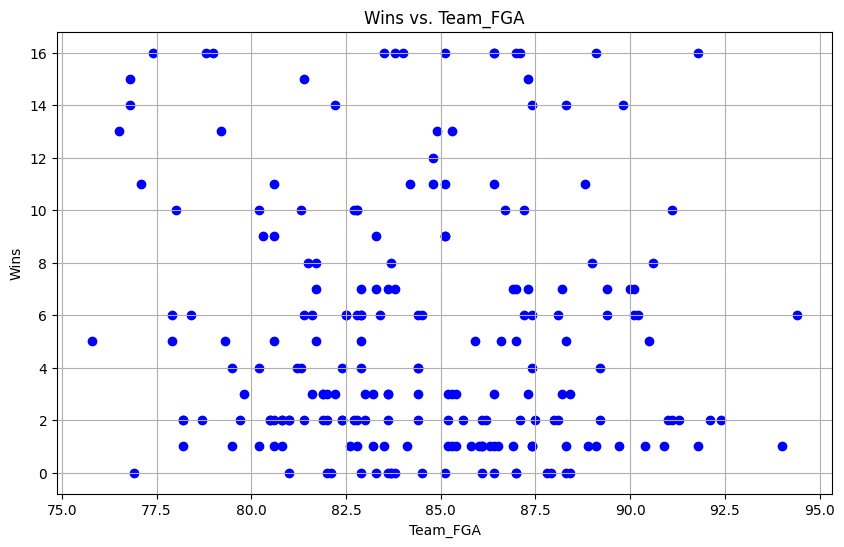

In [12]:
X.head(50)
wins = df_final['Wins']  
rank = df_final['Team_FGA'] 
plt.figure(figsize=(10, 6))
plt.scatter(rank, wins, color='blue')
plt.title('Wins vs. Team_FGA')
plt.xlabel('Team_FGA')
plt.ylabel('Wins')
plt.grid(True)
plt.show()

Here we plot Wins against opponent field goals attempted versus wins. From the scatter plot it is evident that there is not much of a linear relationship between the two. This makes sense as there are NBA teams that take lots of shots but have a low Field goal percentage thus the number of shots doesn't positively impact them. On the other side there may teams that take very less shots however, they are more efficent leading to more wins. Thus looking at that alone doesn't allow us to draw much valuable insights.

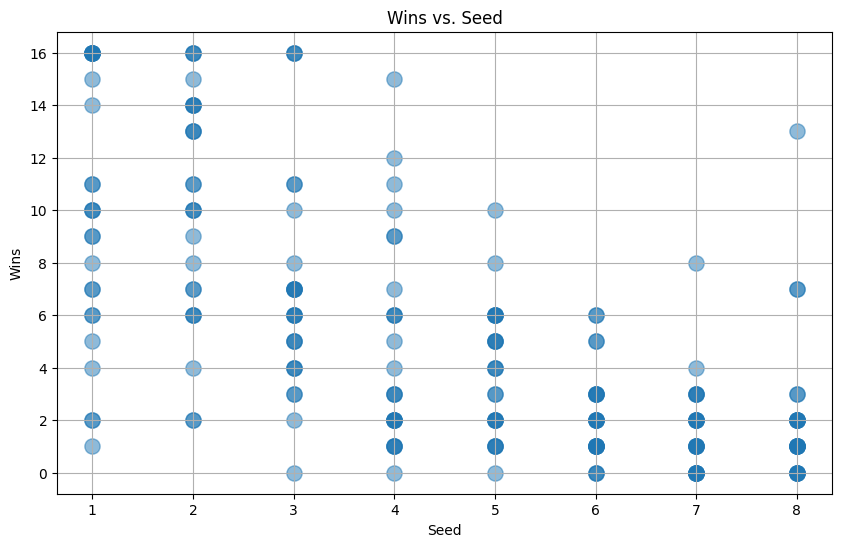

In [13]:
seed = df_final['Seed'] 
plt.figure(figsize=(10, 6))
plt.scatter(seed, wins, alpha=0.5, s=120)
plt.title('Wins vs. Seed')
plt.xlabel('Seed')
plt.ylabel('Wins')
plt.grid(True)
plt.show()

In the plot above we plot Seed versus wins where we can see that it has a much more linear relationship. For teams that have a higher seed going into the playoffs they win more games which is evident in the plot as the color darkens in areas where there are more teams. From this analysis it is safe to say that this will be an important feature in helping us in predicting a teams playoff wins. The higher the seed the more wins.   

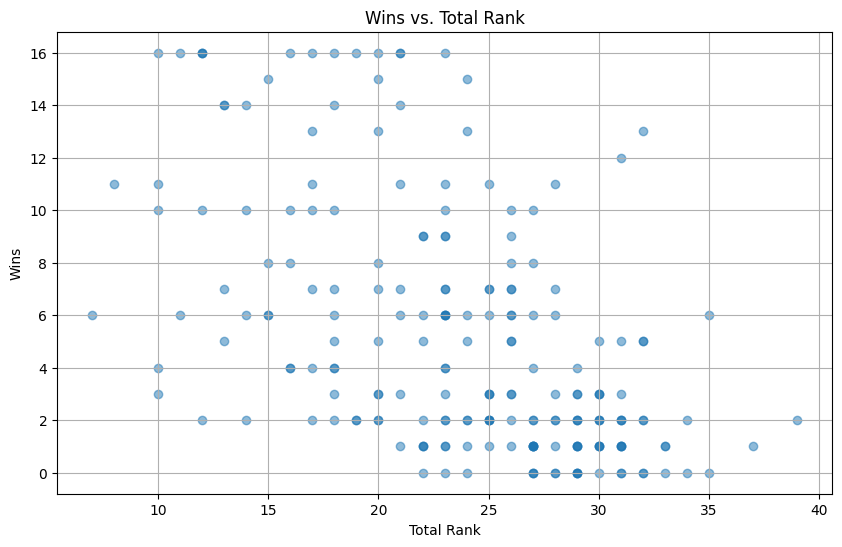

In [14]:
totalRank = df_final['Team_Rk'] +  df_final['Opponent_Rk']
plt.figure(figsize=(10, 6))
plt.scatter(totalRank, wins, alpha=0.5)
plt.title('Wins vs. Total Rank')
plt.xlabel('Total Rank')
plt.ylabel('Wins')
plt.grid(True)
plt.show()

The last graph we look at to help us analyze our different columns before training is wins versus Total Rank. Total rank combines a teams rank as well as opponent rank which looks at how well an opponent plays against a given team. So if a team has a Total Rank of 2 it means they are the best performing team and opponents perform the worst against them. When we look at our graph there is a cutoff around 20-25 games where almost all of the succesfull teams do better than that. This shows us that both team rank as well as opponent rank will be important in our further analysis.

### Exploration Conclusion

Overall from this exploration of the data it is evident that there is some correlation between different features and playoff wins. However, many of the features do not show a direct correlation when looking at the raw data when we look at the P-scores as well as the graphs which may look similar to the scattered nature of Team_FGA. Because of this we can look to PCA in order to create components that may have more linear relationships with playoff wins.

## PCA For Hypothsis Testing

In [15]:
Y = df_final['Wins']  

X = df_final.drop('Wins',axis=1) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print("Number of components after PCA:", pca.n_components_)

X_pca_const = sm.add_constant(X_pca)
print("Length of y:", len(Y))
print("Shape of X_pca_const:", X_pca_const.shape)

model = sm.OLS(Y, X_pca_const).fit()
print(model.summary())

Number of components after PCA: 16
Length of y: 208
Shape of X_pca_const: (208, 17)
                            OLS Regression Results                            
Dep. Variable:                   Wins   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     12.13
Date:                Wed, 15 May 2024   Prob (F-statistic):           1.40e-21
Time:                        00:03:28   Log-Likelihood:                -545.00
No. Observations:                 208   AIC:                             1124.
Df Residuals:                     191   BIC:                             1181.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

# Hypothesis Testing Analysis
With an end goal of identifying which basketball features have the most significant effect on a team’s playoff wins, we first decided to run a normal hypothesis test on our model. Our primary goal was to find the features that were statistically significant, meaning they had a p-value of less than 0.05. However, from this analysis we were shocked to see that there were only 2 features, Seed and Team_FT, with a p-value less than 0.05. Upon review, we realized that having 46 features negatively impacted our model and added too much complexity. Additionally, we noticed that having several features that are highly correlated, such as 3P, 3PA, and 3P%, added the issue of collinearity. There is a clear correlation between 3PA and 3P, as more 3 point attempts means more 3 pointers made. This issue of collinearity complicates the statistical analysis and makes the statistical conclusions unreliable. 

Article highlighting the collinearity between 3 pointers attempted and 3 pointers made: https://www.goldenstateofmind.com/2019/12/1/20990988/do-more-3s-mean-more-wins-what-do-the-numbers-say-what-do-you-say-poll 

### Heat Map To Show Relationship Between Features and PCA Components

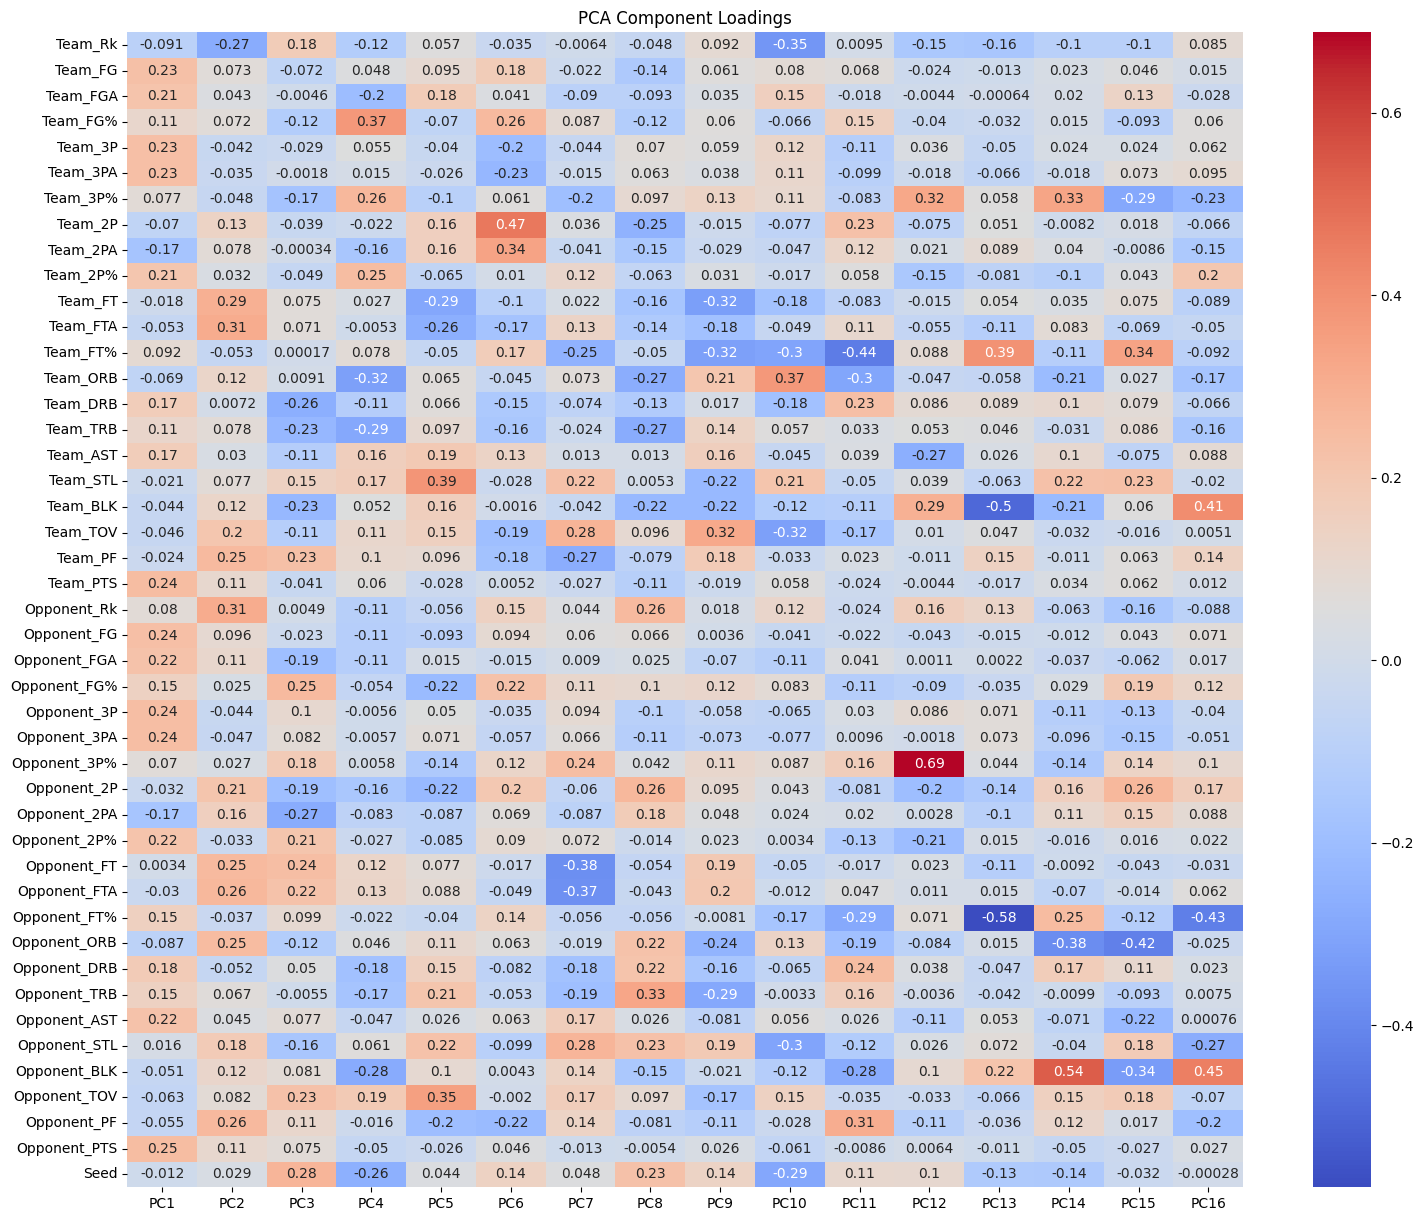

In [16]:
loadings = pca.components_
feature_names = X.columns
loadings_df = pd.DataFrame(data=loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=feature_names)
plt.figure(figsize=(18, 15))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm')
plt.title('PCA Component Loadings')
plt.show()

### Heatmap Explanation
We also decided to implement a Heat Map to visualize how the original features relate to the 16 different principal components. Each feature, principal component pair has an associated color and value. The closer the value is to 0, indicates the insignificance of that specific feature within the respective principal component. This means that blocks with larger values, negative or positive, and darker colors are features that are greatly significant within a principal component. This visualization made it easier for us to take note of how the features vary in significance across the components. 

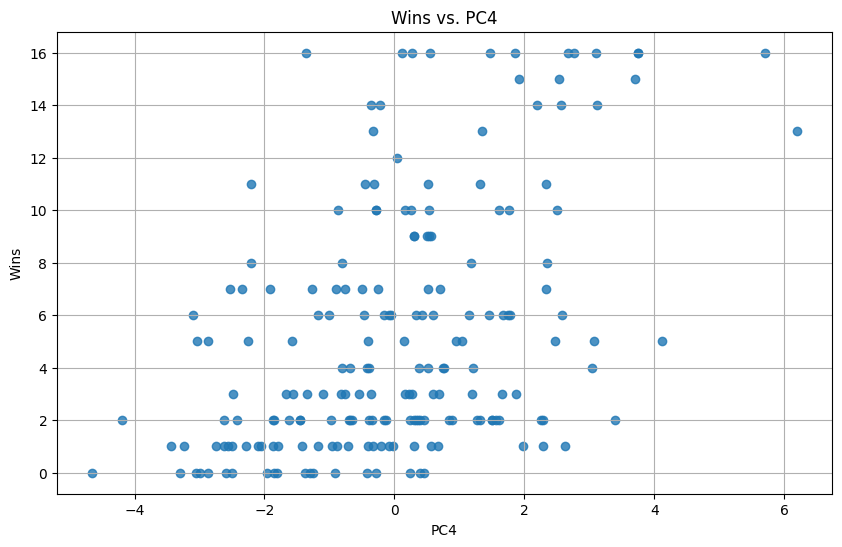

In [17]:
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['Wins'] = wins

component_to_plot1 = 'PC4'

plt.figure(figsize=(10, 6))
plt.scatter(df_pca[component_to_plot1], df_pca['Wins'], alpha=0.8)
plt.title(f'Wins vs. {component_to_plot1}')
plt.xlabel(component_to_plot1)
plt.ylabel('Wins')
plt.grid(True)
plt.show()

PC4 shows a clear positive linear relationship with playoff wins. As PC4 increases so does the amount of wins on average which is represented by its positive T score. As suspected their are outliers as in the NBA it is hard for a model to predict factors such as injuries or certain players having a very good playoff series. Looking further at PC4 some of its most weighted componenents are Team FG% and Team 3P%. As these increase PC4 will increase. This aligns with what we assume as teams that are more efficent generally tend to perform better.

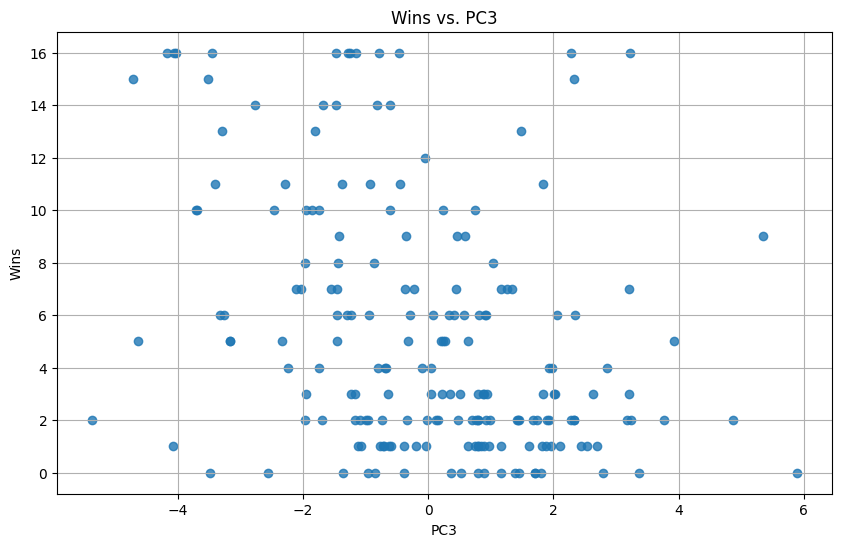

In [18]:
component_to_plot2 = 'PC3'

plt.figure(figsize=(10, 6))
plt.scatter(df_pca[component_to_plot2], df_pca['Wins'], alpha=0.8)
plt.title(f'Wins vs. {component_to_plot2}')
plt.xlabel(component_to_plot2)
plt.ylabel('Wins')
plt.grid(True)
plt.show()

On the other hand we have PC3 which shows a negative correlation which is indicated by its -8.1 T score. This component highlights the negative performance of teams when they play against better opponenens. When opponenets turn the ball over less, score more efficiently, and convert better from the free throw line, teams have a lower chance of winning. This negative correlation is evident in the graph which shows most teams who have a lower PC3 meaning their opponents played worse are more prone to winning games. 

### See Which P Values Are Considered Statistically Significant

In [19]:
summary_frame = model.summary2().tables[1] 
summary_frame = summary_frame.drop('const', axis=0)  

for variable, row in summary_frame.iterrows():
    p_value = row['P>|t|']
    coefficient = row['Coef.']  
    if p_value < 0.05:
        print(f"Variable '{variable}' has a statistically significant effect with a coefficient of {coefficient} and a p-value of {p_value}")

Variable 'x3' has a statistically significant effect with a coefficient of -0.9938649680516314 and a p-value of 4.171951560620778e-14
Variable 'x4' has a statistically significant effect with a coefficient of 1.233293912695553 and a p-value of 6.056864070983399e-17
Variable 'x8' has a statistically significant effect with a coefficient of -0.49007118910844755 and a p-value of 0.004800589728253921
Variable 'x10' has a statistically significant effect with a coefficient of 0.4625619975566343 and a p-value of 0.040025980519164665
Variable 'x12' has a statistically significant effect with a coefficient of -0.5871458231446881 and a p-value of 0.02074817294226253
Variable 'x13' has a statistically significant effect with a coefficient of 0.8704772239333504 and a p-value of 0.0023659009667538968


# PCA Results
As a result, we decided to integrate Principal Component Analysis to minimize the collinearity and reduce the complexity and dimensionality of the data. PCA converts the data into uncorrelated variables, known as principal components. The original data contained 46 features, but PCA brought down to 16 different principal components. This means that the PCA process found linear combinations of the features and identified the sets of features that were the most significant. After conducting PCA, we now have 8 components that have a p-value of less than 0.05 and can be considered statistically significant. We were much more satisfied with these results, as it made it much easier to detect the features that have a significant effect on playoff wins. 

Benefits of PCA testing: https://www.sartorius.com/en/knowledge/science-snippets/what-is-principal-component-analysis-pca-and-how-it-is-used-507186#:~:text=The%20most%20important%20use%20of,variables%2C%20and%20among%20the%20variables.

### Add Seed Information Manually To 2024 Dataset

In [20]:
seed_dict = {
    'Boston Celtics': 1,
    'New York Knicks': 2,
    'Milwaukee Bucks': 3,
    'Cleveland Cavaliers': 4,
    'Orlando Magic': 5,
    'Indiana Pacers': 6,
    'Philadelphia 76ers': 7,
    'Miami Heat': 8,
    'Oklahoma City Thunder': 1,
    'Denver Nuggets': 2,
    'Minnesota Timberwolves': 3,
    'Los Angeles Clippers': 4,
    'Dallas Mavericks': 5,
    'Phoenix Suns': 6,
    'Los Angeles Lakers': 7,
    'New Orleans Pelicans': 8,
}

df_2024['Seed'] = df_2024['Team'].map(seed_dict)

print(df_2024[['Team', 'Seed']])

                       Team  Seed
224          Indiana Pacers     6
225          Boston Celtics     1
226   Oklahoma City Thunder     1
227         Milwaukee Bucks     3
228      Los Angeles Lakers     7
229        Dallas Mavericks     5
230            Phoenix Suns     6
231    Los Angeles Clippers     4
232    New Orleans Pelicans     8
233          Denver Nuggets     2
234      Philadelphia 76ers     7
235  Minnesota Timberwolves     3
236         New York Knicks     2
237     Cleveland Cavaliers     4
238           Orlando Magic     5
239              Miami Heat     8


# Machine Learning

### Run Gradient Descent Regression

In [ ]:
train_set, test_set = train_test_split(df_final, test_size=0.20, random_state=42)

X_train = train_set.drop('Wins', axis=1)
y_train = train_set['Wins']
X_test = test_set.drop('Wins', axis=1)
y_actual = test_set['Wins']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

X_train_pca = np.c_[np.ones((X_train_pca.shape[0], 1)), X_train_pca]
X_test_pca = np.c_[np.ones((X_test_pca.shape[0], 1)), X_test_pca]

def grad_descent(X, y, T, alpha):
    m, n = X.shape
    theta = np.zeros(n)
    f = np.zeros(T)
    for i in range(T):
        pred = X.dot(theta)
        err = pred - y
        f[i] = 0.5 / m * np.sum(err ** 2)
        g = X.T.dot(err) / m
        theta = theta - alpha * g
    return theta, f

T = 25000
alpha = 0.0001

theta, loss = grad_descent(X_train_pca, y_train, T, alpha)

Here we use regression as our first approach to predict the number of wins. First we prepared all of our data for training, transformed, performed PCA and then created both our test and train datasets. Finally we performed regressions using gradient descent to optimze our performance and reduce the likelihood of overfitting for outliers. This is important in the context of basketball as teams can often under or over perform expections and we want our model to still generalize. 

### Error Statistics and Predicted vs. Actual Wins

In [ ]:
y_pred = X_test_pca.dot(theta)

mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

results_df = pd.DataFrame({'Predicted Wins': y_pred, 'Actual Wins': y_actual})

print(results_df.head(10)) 
print("\nMean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-Squared:", r2)

**The Mean Absolute error of this model is roughly 2 indicating our model is off by about 2 games.** 

### Plot Loss Predicted vs. Actual Wins and Loss Over Epochs

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, alpha=0.75)
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Predicted Wins vs Actual Wins')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2)
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(T), loss, label='Loss over epochs')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss Function Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

**Now by plotting our regression line against the actual data points we can get a good indication of how our model is performing on our training data set. We can also take a look at the loss function which shows a clear indicator that the model was working.** 

### See Predictions For 2024

In [ ]:
X_2024 = df_2024.drop(['Team'], axis=1) 
X_2024 = X_2024.drop(['Team_G', 'Team_MP', 'Opponent_G', 'Opponent_MP', 'Year'], axis=1)

X_2024_scaled = scaler.transform(X_2024)

X_2024_pca = pca.transform(X_2024_scaled)

X_2024_pca = np.c_[np.ones((X_2024_pca.shape[0], 1)), X_2024_pca]

y_2024_pred = X_2024_pca.dot(theta)

results_2024_df = pd.DataFrame({
    'Team': df_2024['Team'],
    'Predicted Playoff Wins': y_2024_pred
})

print(results_2024_df)

**Above we gathered our team data for the 2024 playoff teams and scaled, transformed and ran PCA on it. Then we git it to our model using the dot product and got the results of how these teams would play.** 

#### Our linear regerssion model using gradient descent had good results but can we do better?

### Model For RandomForestRegressor

In [ ]:
train_set, test_set = train_test_split(df_final, test_size=0.20, random_state=42)

X_train = train_set.drop('Wins', axis=1)
y_train = train_set['Wins']
X_test = test_set.drop('Wins', axis=1)
y_actual = test_set['Wins']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_reg = RandomForestRegressor(n_estimators=80, random_state=42)

rf_reg.fit(X_train_scaled, y_train)

**In order to perform this regression we first created our train and test sets made sure to fit all of the data properly and scale as well. We then performed Random Forest Fegression on it in order to obtain the weights for our model.** 

### Error Statistics and Predicted vs. Actual Wins

In [ ]:
y_pred = rf_reg.predict(X_test_scaled)
mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

results_df = pd.DataFrame({'Predicted Wins': y_pred, 'Actual Wins': y_actual})

print(results_df.head(20)) 
print("\nMean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-Squared:", r2)

**Using this model we get a slightly better performance as our mean absolute error has decreased from above 2 using gradient descent to below 2 using Random Forest Regressions**

### Plot Predicted vs Actual Wins

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, alpha=0.75)
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Predicted Wins vs Actual Wins')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2)
plt.grid(True)
plt.show()

# Insight and Policy Decision

### Predict For 2024

In [ ]:
X_2024 = df_2024.drop(['Team', 'Team_G', 'Team_MP', 'Opponent_G', 'Opponent_MP', 'Year'], axis=1, errors='ignore')

X_2024_scaled = scaler.transform(X_2024)

y_2024_pred = rf_reg.predict(X_2024_scaled)

results_2024_df = pd.DataFrame({
    'Team': df_2024['Team'],
    'Predicted Playoff Wins': y_2024_pred
})

print(results_2024_df)

plt.figure(figsize=(10, 6))
plt.scatter(results_2024_df['Team'], results_2024_df['Predicted Playoff Wins'], alpha=0.75)
plt.xticks(rotation=90)
plt.ylabel('Predicted Playoff Wins')
plt.title('Predicted Playoff Wins for 2024 Teams')
plt.grid(True)
plt.show()

**Plotted above are the predictions for the 2024 NBA playoffs. While we are still midway through the playoffs we can analyze this to see how well our model is performing as well as shed light on where the value of our model comes in to play.**   

While not a perfect indicator of the amount of playoff wins, our model can offer valuable insights into which teams will perform better. Basketball is a sport and like any other sport it is not a perfectly linear game. Playing a perfect game from the perspective of a data analysts mind doesn't always mean reality will mirror that.  

However, if we look at the matchups in the nba playoffs for this year our model correctly predicted more wins for 6 out of the 8 first round matchups. In the 2 that were incorrectly predicted, the team that was upset had star players injured for the playoff matchups. 

In recent years there has been a huge spike in sports betting as well as fantasy sports. This could be a great way for viewers to become more informed on their betting decisions and who they decide to play in fantasy sports. Outside of that, these models can help in the creation of merchandise for the winning teams. Companies usually create merchandise for both teams playing in advance, in order to stay ready for people eager to buy clothes when a team wins. Instead if we know that one team will most likely win many more games that can be used to help reduce waste an excess resources. 

Finally for the NBA teams themselves it can be used as a metric to help them determine if they are in a rebuild or win-now mode. Knowing that they have the statistics that support a deep playoff run they may look to add key pieces to shore up their changes of making that run and ultimitely having a chance to win the NBA Championship.

We hope that through this tutorial you have been able to get an indepth view of the of the data science pipline from Data Scraping -> Data Processing -> Exploratory Data Analysis -> Hyopthesis Testing -> Machine -> Insights and Analytics. Seeing how raw data can be transformed into meaning insights is a key skill that can be used across nearly every industry and this gives a glimpse into how it can be done in a field that is growing ever more reliant on data analytics. 